In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint
from itertools import combinations, cycle, islice
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, FeatureAgglomeration
from sklearn.feature_extraction import DictVectorizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [2]:
from metagov import cryptopolitics
from metagov.cryptopolitics import SAVEDIR, QUESTIONS, COLS_QUESTIONS, COLS_RESULTS, FACTION_ORDERS, n2q

In [3]:
SAVEFIG = False
fig_ext = '.png'
fig_kwargs = cryptopolitics.KWARGS_PNG

In [4]:
# In case a lot of clusters are found
COLORS = np.array(sns.color_palette('bright').as_hex() + \
                  sns.color_palette('pastel').as_hex() + \
                  sns.color_palette('dark').as_hex() + \
                  sns.color_palette('muted').as_hex())
COLORS_MIN = np.array(sns.color_palette("cubehelix").as_hex())

# Cryptopolitical Typology Quiz analysis - dimensionality reduction and factor analysis

The [Cryptopolitical Typology Quiz](https://metagov.typeform.com/cryptopolitics) was developed by the [Metagovernance Project](https://metagov.org/) to help the crypto community understand its political, economic, and governance beliefs. Survey results were collected from September 27, 2021 through March 4, 2022 and have been published on the [Govbase Airtable database](https://airtable.com/shr9LYMni8pBUVD6q/tblvwbt4KFm8MOSUQ). 

In [5]:
data = cryptopolitics.load_data()
df_questions, df_results = data.values()

## Method
We built the initial set of factions by hand, but we were curious whether these or factions and features might arise naturally from the data. To look for these, we used feature selection methods (e.g. PCA, feature agglomeration). The hope was to identify and describe groupings of questions in a meaningful way. We might hope to find axes that correspond to something like the "politics" or "economics" axes defined in the survey, or some other belief/value axis not yet identified. These would allow us to view the data as projected onto these axes.
    
- **PCA (principal component analysis)** (mixed encoding only)
- **Feature agglomeration**

An alternative method that could be relevant here is multiple correspondence analysis.

Steps involved:
- **Preprocessing** (how to encode the data)
- **Feature selection** (to find which questions most explain variance between respondents) and **dimensionality reduction** (to visualize the clusters; could also be a preprocessing step), i.e., grouping the questions by the responses

General process notes:
- For many clustering methods, the **distance** or **affinity** metric chosen greatly affects the resulting fit. Since ultimately this data is categorical, wherever there was the option, "manhattan" (cityblock) distance was chosen.

## Preprocessing
- Drop questions relating to specific ecosystems (Q2, Q19)
- Drop rows with any unanswered questions
- **Encode the data** in two ways:
    - **Categorical**: All questions one-hot encoded (49 columns)
    - **Mixed**: All but four categorical questions mapped to ordinal values on -1 to 1 scale, with the remaining questions one-hot encoded (29 columns). The one-hot encoded values are rescaled to reduce their weight relative to the ordinal encoded questions, since each question was split up into four features. *Warning*: this ordinal mapping, done subjectively, greatly affects subsequent results! See the .csv file for the mapping definition.

In [6]:
# Preprocessing
df_tmp = df_questions.copy().drop(columns=['Q2', 'Q19'])
df_to_cluster = df_tmp.dropna()
df_result_to_cluster = df_results.loc[df_to_cluster.index, :]
COLS_QUESTIONS_clustering = COLS_QUESTIONS.copy()
COLS_QUESTIONS_clustering.remove('Q2')
COLS_QUESTIONS_clustering.remove('Q19')

In [7]:
def get_color(faction):
    return list(df_result_to_cluster[faction].apply(lambda x: COLORS_MIN[FACTION_ORDERS[faction].index(x)]))

colors_pol = get_color('politics')
colors_econ = get_color('economics')
colors_gov = get_color('governance')

In [8]:
# Import ordinal mapping from file
df_map = pd.read_csv('data/cryptopolitics_quiz_cluster_mapping.csv')
gb_map = df_map.groupby('Question')

# Convert to dictionary
mappingDict = {}
for key, value in gb_map:
    
    df_q = gb_map.get_group(key)
    questionDict = {}
    for i, row in gb_map.get_group(key).iterrows():
        try:
            m = float(row['Mapping'])
        except ValueError:
            m = row['Mapping']
        questionDict[row['Answer']] = m
    
    mappingDict[key] = questionDict

# Rename dictionary items for ease of working with it
mappingDict = {n2q(k): v for (k, v) in mappingDict.items()}

# Get mapped version of full response DataFrame
df_mapped = df_to_cluster.copy()
for col in df_mapped.columns:
    df_mapped[col] = df_mapped[col].map(mappingDict[col])

print("Mixed ordinal and categorical encoding of the data:")
df_mapped.head()

Mixed ordinal and categorical encoding of the data:


,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
id,,,,,,,,,,,,,,,,,
3462,1.0,-1.0,D,0.333,1.0,0.0,1.0,D,1.0,-1.0,1.0,1.0,-0.333,-1.0,C,C,-1.0
2024,-1.0,-1.0,C,0.333,-1.0,1.0,-1.0,C,1.0,1.0,1.0,1.0,0.333,-1.0,B,C,0.0
2135,-1.0,1.0,B,1.000,1.0,1.0,-1.0,C,1.0,1.0,-1.0,-1.0,-1.000,-1.0,D,D,1.0
449,1.0,-1.0,B,0.333,1.0,1.0,-1.0,A,1.0,-1.0,-1.0,-1.0,-1.000,1.0,B,A,0.0
717,1.0,-1.0,C,1.000,1.0,1.0,-1.0,C,1.0,-1.0,1.0,-1.0,-1.000,-1.0,C,C,0.0


#### Categorical encoding (one-hot)

In [9]:
# Encode categorical questions as one-hot
v = DictVectorizer(sparse=False)
cols_categorical = [n2q(x) for x in [4,9,16,17]]
X_categorical = v.fit_transform(df_mapped[cols_categorical].to_dict(orient='records'))
df_categorical = pd.DataFrame(X_categorical, columns=v.get_feature_names_out())

# Rescale one-hot columns
# This must be set manually based on the coded values!
scaleBy = 0.5 # ordinal_range*(1/n_possible_responses) = (1-(-1))*(1/4); assumes both are constant across questions
df_categorical = df_categorical.multiply(scaleBy) 

# Merge with ordinal to create mixed ordinal-categorical data
df_ordinal = df_mapped.drop(columns=cols_categorical)
df_mixed = pd.concat([df_ordinal.reset_index(drop=True), df_categorical], axis=1)
X_mixed = df_mixed.to_numpy()

df_mixed.shape

(3418, 29)

#### Mixed encoding (ordinal and categorical)

In [10]:
# Encode all questions as one-hot (only categorical data)
v = DictVectorizer(sparse=False)
X_allCat = v.fit_transform(df_to_cluster.to_dict(orient='records'))
df_allCat = pd.DataFrame(X_allCat, columns=v.get_feature_names_out())

df_allCat.shape

(3418, 48)

In [27]:
def scatter_plot_combos(X, N, colors=None, title=''):
    """Given X with shape (n_samples, n_dimensions) where n_dimensions may be >2,
    plot each combination of dimensions as a 2D scatter plot, with colors optionally specified"""
    
    color = cryptopolitics.DEFAULT_COLOR
    if colors is not None:
        color = colors
    if title != '':
        title = title + ': '
    
    for combo in list(combinations(list(range(N)), 2)):
        plt.figure()
        plt.scatter(X[:,combo[0]], X[:,combo[1]], color=color, alpha=0.25)
        plt.xlabel(combo[0])
        plt.ylabel(combo[1])
        plt.title(f"{title}n_components = {N} {combo}")

## PCA
Besides providing a set of axes on which to project the data for visualization, the first few PCA components could help us understand which questions are most important in explaining variance between respondents. An important caveat: since PCA assumes numerical data, the component values do not correspond exactly to possible encoded answer values. By snapping these values to the nearest possible answer, we can get an approximation of this.

In [12]:
def compute_and_plot_pca(X, N, labels=None, colors=None):
    """Compute and plot PCA transformation of data"""
    
    # Transform
    pca = PCA(n_components=N)
    X_transformed = pca.fit_transform(X)

    print(f"Total variance explained by {N} components: {100*sum(pca.explained_variance_ratio_):.1f}%")    
    
    # Display PCA vectors against one another
    df_tmp = pd.DataFrame(np.transpose(pca.components_))
    if labels is not None:
        df_tmp.index = labels
    if len(df_tmp.columns) > 3:
        df_tmp = df_tmp.iloc[:, :3]
    df_tmp.plot.bar(width=0.8, figsize=(12,6))
    plt.ylabel('Component value\n(note: scale for ordinal is different from that of categorical)')

    # Print "nearest possible" response value for the first three PCA components
    df_tmp2 = (snap_to_nearest_value(df_tmp.transpose())).transpose()
    print(f"Questions for which the components had different nearest-possible responses:\n\t",
      ", ".join(cryptopolitics.columns_where_rows_differ(df_tmp2.transpose())))
    
    if SAVEFIG:
        # Save original and closest-possible-response versions of results for interpretation
        df_tmp.to_csv(f"{SAVEDIR}/cryptopolitics_pca.csv")
        df_tmp2.to_csv(f"{SAVEDIR}/cryptopolitics_pca_snapto.csv")
    
    # Scree plot
    plt.figure()
    plt.plot(np.arange(pca.n_components_) + 1, 100*pca.explained_variance_ratio_,
                'o-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.show()

    # Plot
    scatter_plot_combos(X_transformed, min(N, 3), title='PCA', colors=colors)

    return X_transformed, pca

In [13]:
def snap_to_nearest_value(df):
    """For use with PCA or other vectors that do not correspond exactly to possible answer values.
    
    This is used to help understand which specific questions/responses may play the largest role
    in explaining variance between respondents"""
    
    TOL = 0.85 # How close is "close enough" to a possible response? 0 = exact match.
    MAX_VAL = 0.5 # Assuming Really should 
    
    df_snapto = df.copy()
    for i, row in df.iterrows():
        for col in df.columns:
            qnum = col
            if '=' in col:
                qnum, _ = col.split('=')
            val = row[col]
                
            valsList = sorted(mappingDict[qnum].values())

            if '=' not in col:
                # Method for ordinal values
                valsSpan = valsList[-1] - valsList[0]
                nVals = len(valsList)
                nearestVals = [x for x in valsList if abs(x - val) < TOL*((valsSpan/2)/(nVals-1))]
                if len(nearestVals) == 0:
                    snap_to = np.nan
                else:
                    snap_to = nearestVals[0]
                    if len(nearestVals) > 1:
                        print(f"col {col} has more than one nearest value, i.e., fix your formula!")
            else:
                # Method for categorical values
                if abs(MAX_VAL - val) < TOL*MAX_VAL/2:
                    snap_to = MAX_VAL
                else:
                    snap_to = 0
            
            df_snapto.at[i, col] = snap_to
            
    return df_snapto

### PCA on mostly-ordinal data
Not really meaningful for one-hot-encoded data. Display only first three components for convenience.

In [ ]:
n_PCA = 17 # Number of questions included in this analysis

Total variance explained by 17 components: 97.8%
Questions for which the components had different nearest-possible responses:
	 Q3, Q5, Q6, Q8, Q14, Q15


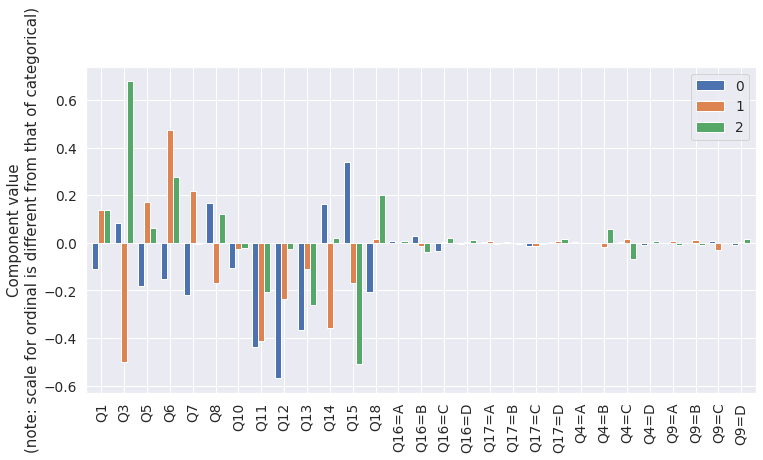

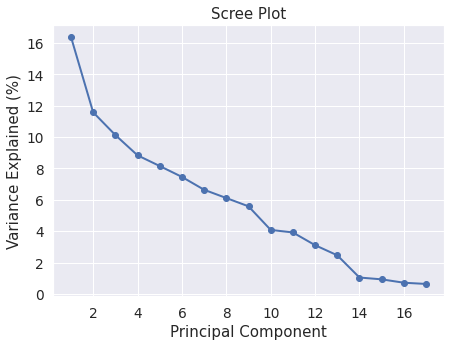

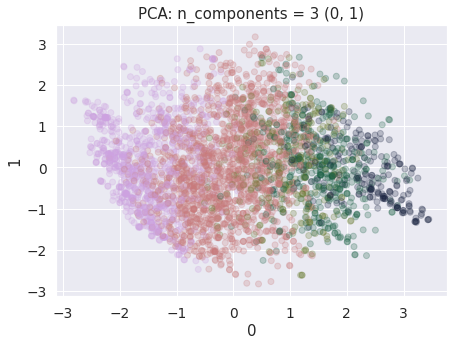

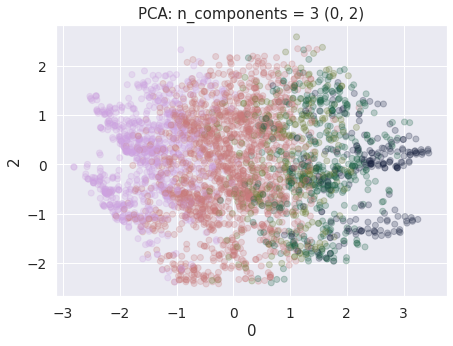

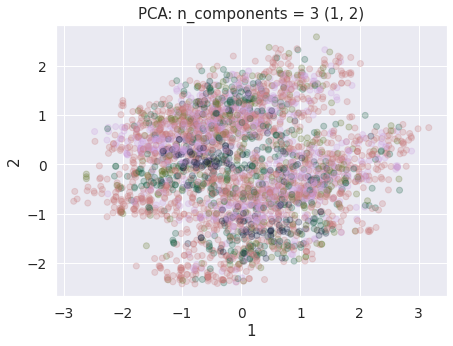

In [28]:
# Plot with political faction colors
X_pca, pca_result = compute_and_plot_pca(X_mixed, n_PCA, 
                                         labels=list(df_mixed.columns), 
                                         colors=colors_pol)

Total variance explained by 17 components: 97.8%
Questions for which the components had different nearest-possible responses:
	 Q3, Q5, Q6, Q8, Q14, Q15


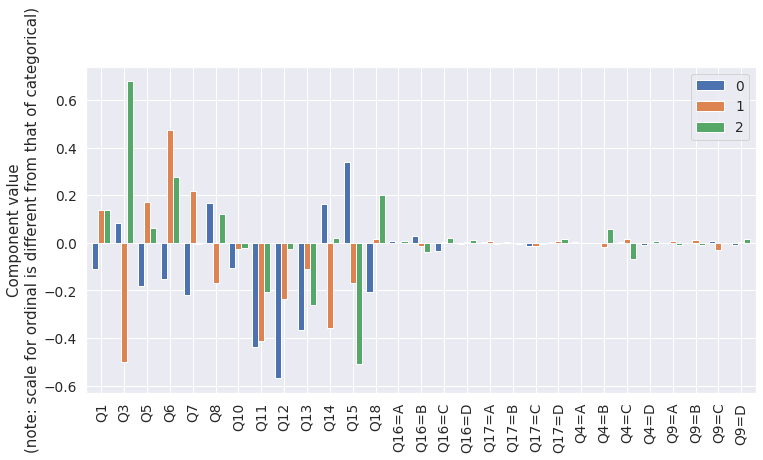

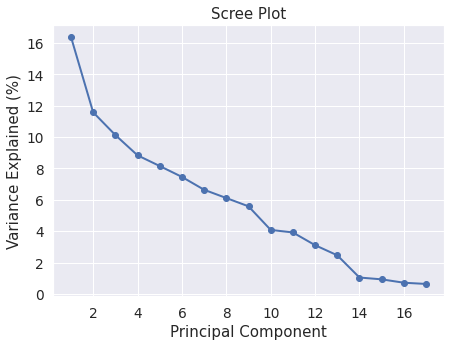

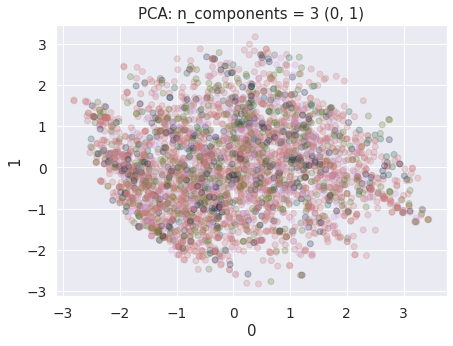

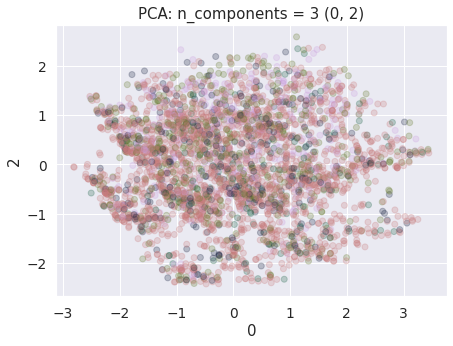

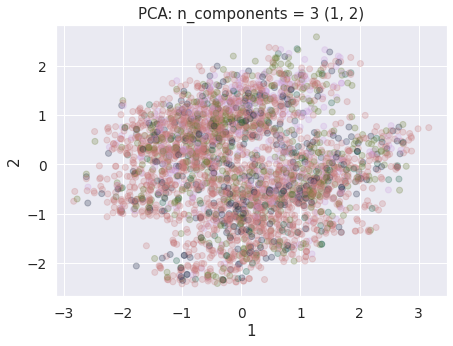

In [29]:
# Plot with economic faction colors
X_pca, pca_result = compute_and_plot_pca(X_mixed, n_PCA, 
                                         labels=list(df_mixed.columns), 
                                         colors=colors_econ)

Total variance explained by 17 components: 97.8%
Questions for which the components had different nearest-possible responses:
	 Q3, Q5, Q6, Q8, Q14, Q15


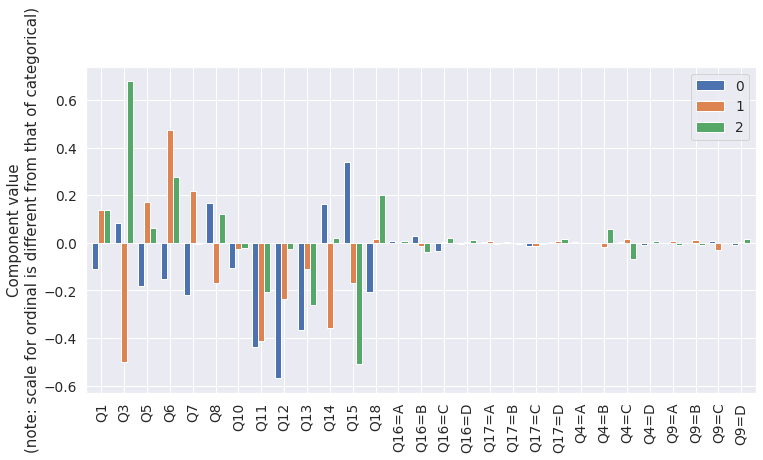

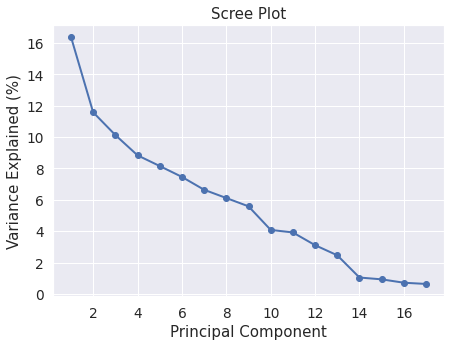

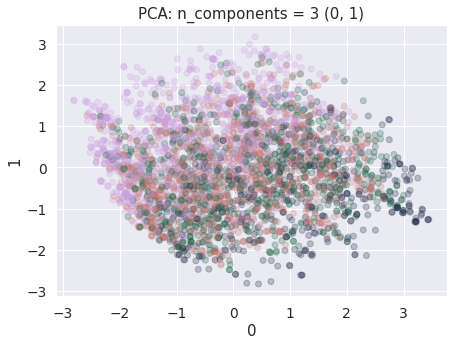

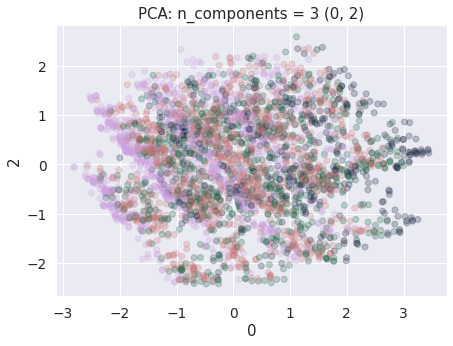

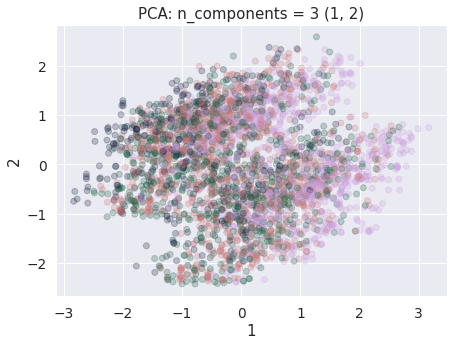

In [30]:
# Plot with governance class colors
X_pca, pca_result = compute_and_plot_pca(X_mixed, n_PCA, 
                                         labels=list(df_mixed.columns), 
                                         colors=colors_gov)

Based on the PCA component values, Q3, Q5, Q14 (government regulation), Q15 (gender) may play the greatest role in differentiating respondents. However, the variance explained by the first 2-3 components is fairly low (less than 50%), so these results are pretty weak.

Even so, we'll use these components to visualize the clustering later.

#### Feature agglomeration

In [15]:
def compute_and_plot_feature_agglomeration(X, N, labels=None, kwargs={}, colors=None):
    """Compute and plot feature agglomeration transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    fa = FeatureAgglomeration(n_clusters=N, **kwargs) #cosine, cityblock, hamming, dice
    X_transformed = fa.fit_transform(X)

    # Display some results
    if labels is not None:
        features = pd.DataFrame([{'question': labels[i], 'feature': x} for (i, x) in enumerate(fa.labels_)])
        gb = features.groupby(by='feature')
        for key, item in gb:
            print(gb.get_group(key), "\n\n")
    
    # Plot
    scatter_plot_combos(X_transformed, N, title=f'Feature Agglomeration ({kwargs})',
                        colors=colors)

    return X_transformed, fa

In [42]:
kwargs_fa_allCat = {'affinity': 'manhattan', 'linkage': 'complete'}
kwargs_fa_mixed = {'affinity': 'manhattan', 'linkage': 'complete'}#{'affinity': 'cosine', 'linkage': 'single'}
nFeatures = 3

                                             question  feature
0   Q10=Blockchain and DeFi are beneficial technol...        0
3   Q11=Most crypto teams make a fair and reasonab...        0
4   Q12=The economic system in crypto is generally...        0
7   Q13=Most people who want to get ahead in crypt...        0
11  Q14=Work hand-in-hand with regulators to ident...        0
12         Q15=Crypto does not have a gender problem.        0
21                                       Q17=the tech        0
24                                        Q18=Neither        0
25                Q1=There is no one best blockchain.        0
28        Q3=Crypto is mainly an economic technology.        0
37  Q6=Privacy is nice, but it’s not the most impo...        0
39  Q7=Government regulation of crypto can do some...        0
42  Q8=Having a central bank run a cryptocurrency ...        0
45  Q9=Build useful tech that solve real problems ...        0 


                                             questio

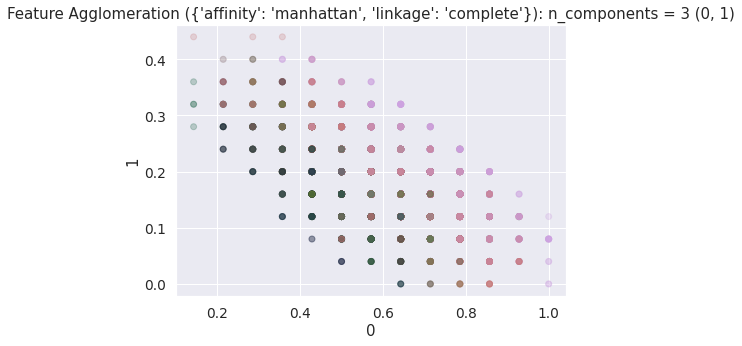

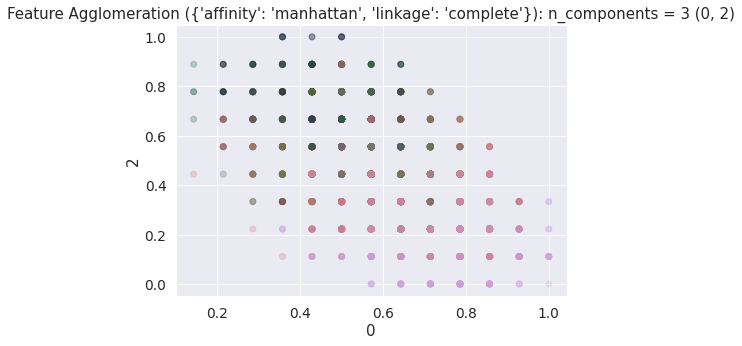

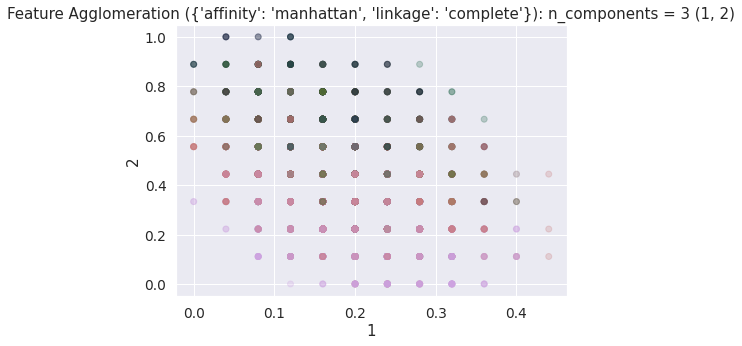

In [43]:
# Feature agglomeration on categorical data - 4 features
# Plot with political faction colors
X_fa_allCat, fa_result_allCat = compute_and_plot_feature_agglomeration(X_allCat, nFeatures,
                                                                       labels=df_allCat.columns,
                                                                       kwargs=kwargs_fa_allCat,
                                                                       colors=colors_pol)

                                             question  feature
0   Q10=Blockchain and DeFi are beneficial technol...        0
3   Q11=Most crypto teams make a fair and reasonab...        0
4   Q12=The economic system in crypto is generally...        0
7   Q13=Most people who want to get ahead in crypt...        0
11  Q14=Work hand-in-hand with regulators to ident...        0
12         Q15=Crypto does not have a gender problem.        0
21                                       Q17=the tech        0
24                                        Q18=Neither        0
25                Q1=There is no one best blockchain.        0
28        Q3=Crypto is mainly an economic technology.        0
37  Q6=Privacy is nice, but it’s not the most impo...        0
39  Q7=Government regulation of crypto can do some...        0
42  Q8=Having a central bank run a cryptocurrency ...        0
45  Q9=Build useful tech that solve real problems ...        0 


                                             questio

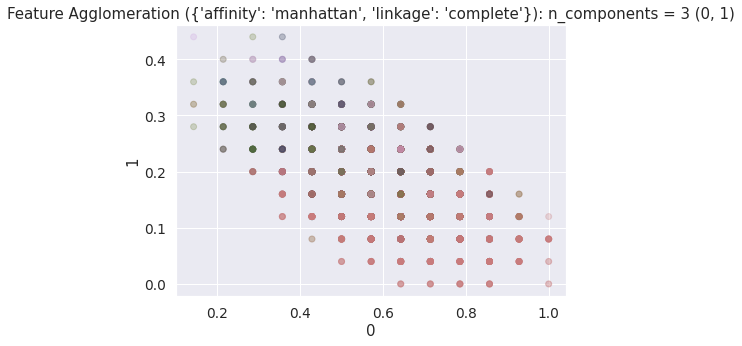

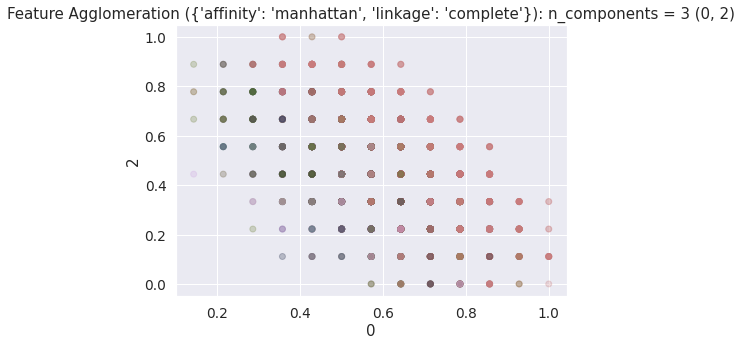

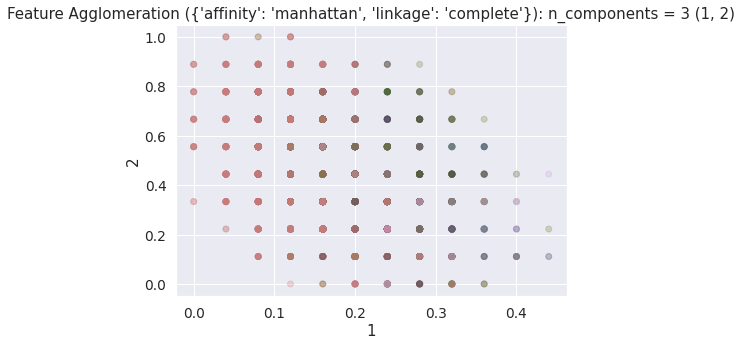

In [44]:
# Plot with economic faction colors
X_fa_allCat, fa_result_allCat = compute_and_plot_feature_agglomeration(X_allCat, nFeatures,
                                                                       labels=df_allCat.columns,
                                                                       kwargs=kwargs_fa_allCat,
                                                                       colors=colors_econ)

                                             question  feature
0   Q10=Blockchain and DeFi are beneficial technol...        0
3   Q11=Most crypto teams make a fair and reasonab...        0
4   Q12=The economic system in crypto is generally...        0
7   Q13=Most people who want to get ahead in crypt...        0
11  Q14=Work hand-in-hand with regulators to ident...        0
12         Q15=Crypto does not have a gender problem.        0
21                                       Q17=the tech        0
24                                        Q18=Neither        0
25                Q1=There is no one best blockchain.        0
28        Q3=Crypto is mainly an economic technology.        0
37  Q6=Privacy is nice, but it’s not the most impo...        0
39  Q7=Government regulation of crypto can do some...        0
42  Q8=Having a central bank run a cryptocurrency ...        0
45  Q9=Build useful tech that solve real problems ...        0 


                                             questio

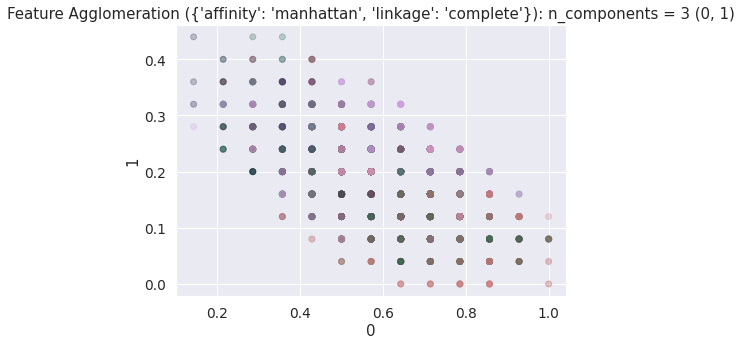

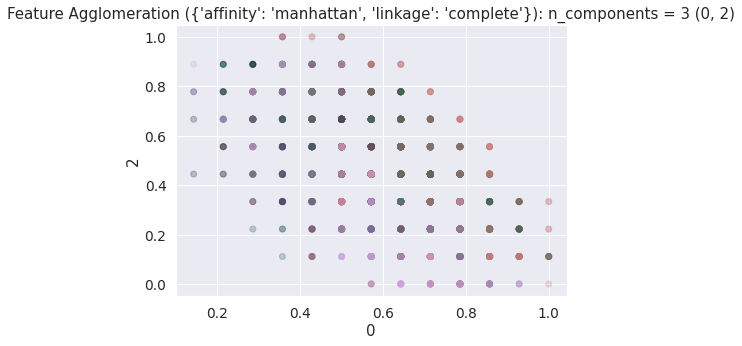

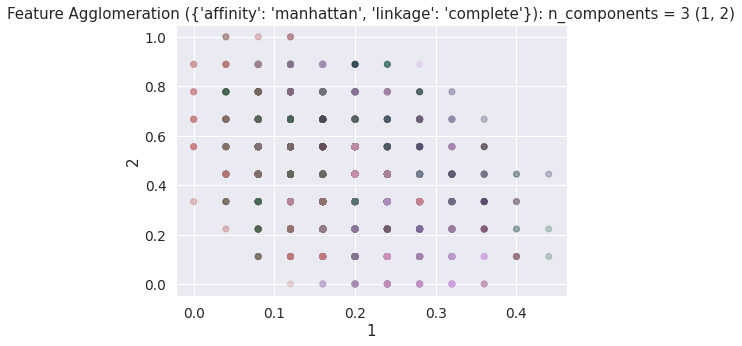

In [32]:
# Plot with governance class colors
X_fa_allCat, fa_result_allCat = compute_and_plot_feature_agglomeration(X_allCat, nFeatures,
                                                                       labels=df_allCat.columns,
                                                                       kwargs=kwargs_fa_allCat,
                                                                       colors=colors_gov)

The features grouped with this method could have some relation to the politics/economics/governance question groups we defined for the faction assignments. Next time around, could programmatically compare the two sets of groupings. 

   question  feature
1        Q3        0
6       Q10        0
7       Q11        0
8       Q12        0
9       Q13        0
10      Q14        0 


   question  feature
0        Q1        1
3        Q6        1
5        Q8        1
11      Q15        1 


   question  feature
2        Q5        2
4        Q7        2
12      Q18        2
13    Q16=A        2
14    Q16=B        2
15    Q16=C        2
16    Q16=D        2
17    Q17=A        2
18    Q17=B        2
19    Q17=C        2
20    Q17=D        2
21     Q4=A        2
22     Q4=B        2
23     Q4=C        2
24     Q4=D        2
25     Q9=A        2
26     Q9=B        2
27     Q9=C        2
28     Q9=D        2 




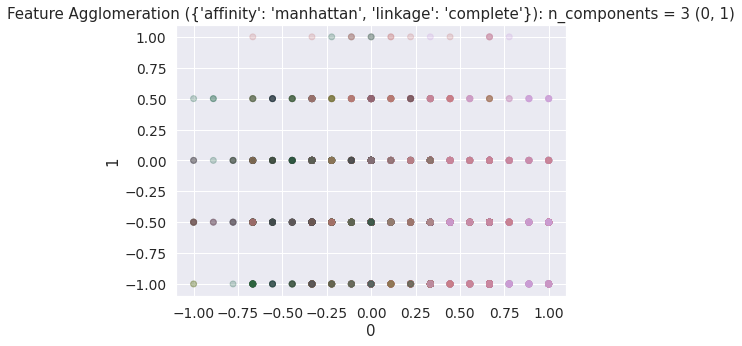

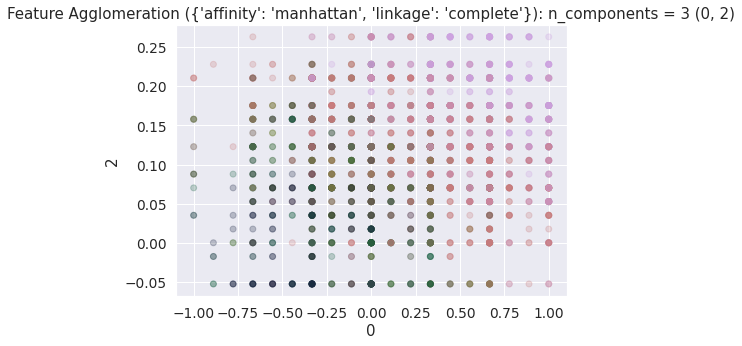

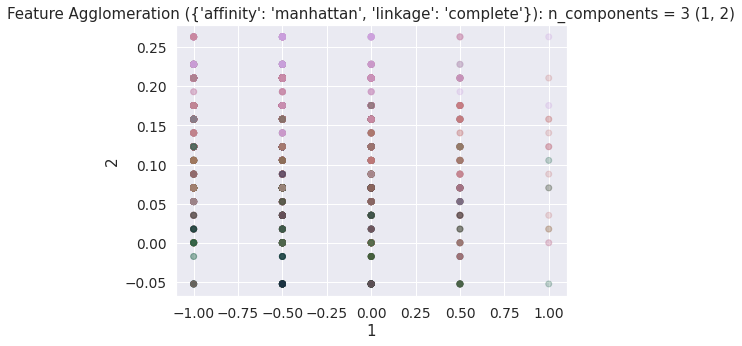

In [35]:
# Feature agglomeration on mixed data - 2 features
# Plot with political faction colors
X_fa_mixed, fa_result_mixed = compute_and_plot_feature_agglomeration(X_mixed, 3, 
                                                                     labels=df_mixed.columns,
                                                                     kwargs=kwargs_fa_mixed,
                                                                     colors=colors_pol)

   question  feature
1        Q3        0
6       Q10        0
7       Q11        0
8       Q12        0
9       Q13        0
10      Q14        0 


   question  feature
0        Q1        1
3        Q6        1
5        Q8        1
11      Q15        1 


   question  feature
2        Q5        2
4        Q7        2
12      Q18        2
13    Q16=A        2
14    Q16=B        2
15    Q16=C        2
16    Q16=D        2
17    Q17=A        2
18    Q17=B        2
19    Q17=C        2
20    Q17=D        2
21     Q4=A        2
22     Q4=B        2
23     Q4=C        2
24     Q4=D        2
25     Q9=A        2
26     Q9=B        2
27     Q9=C        2
28     Q9=D        2 




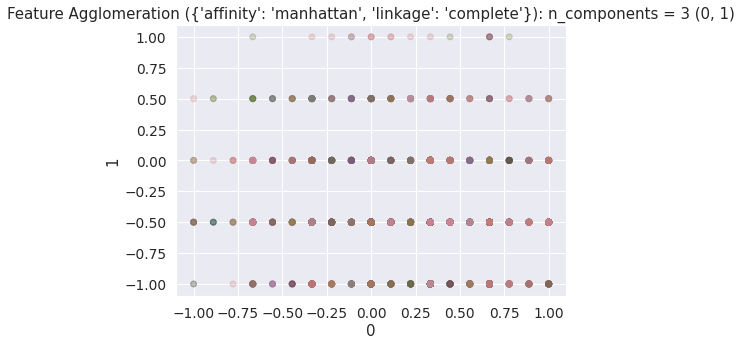

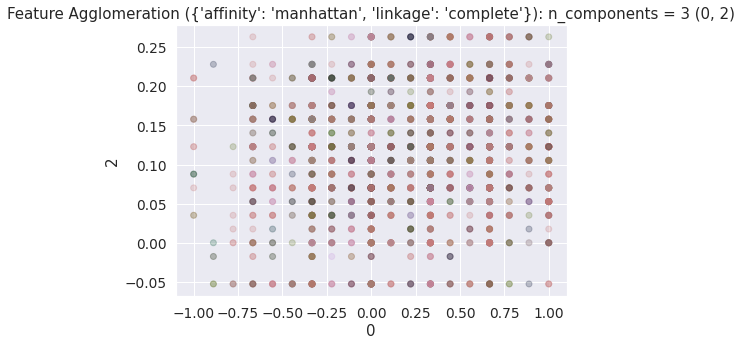

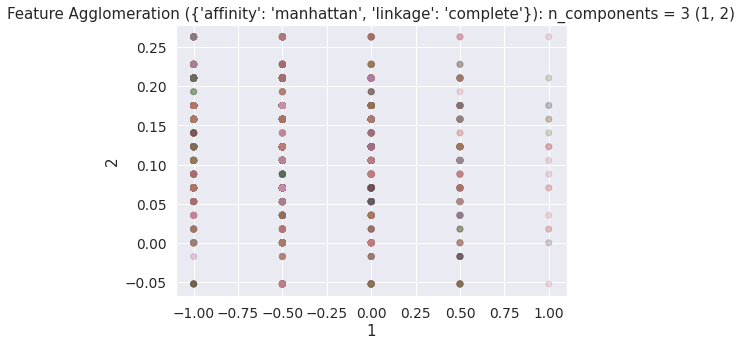

In [36]:
# Plot with economic faction colors
X_fa_mixed, fa_result_mixed = compute_and_plot_feature_agglomeration(X_mixed, 3, 
                                                                     labels=df_mixed.columns,
                                                                     kwargs=kwargs_fa_mixed,
                                                                     colors=colors_econ)

   question  feature
1        Q3        0
6       Q10        0
7       Q11        0
8       Q12        0
9       Q13        0
10      Q14        0 


   question  feature
0        Q1        1
3        Q6        1
5        Q8        1
11      Q15        1 


   question  feature
2        Q5        2
4        Q7        2
12      Q18        2
13    Q16=A        2
14    Q16=B        2
15    Q16=C        2
16    Q16=D        2
17    Q17=A        2
18    Q17=B        2
19    Q17=C        2
20    Q17=D        2
21     Q4=A        2
22     Q4=B        2
23     Q4=C        2
24     Q4=D        2
25     Q9=A        2
26     Q9=B        2
27     Q9=C        2
28     Q9=D        2 




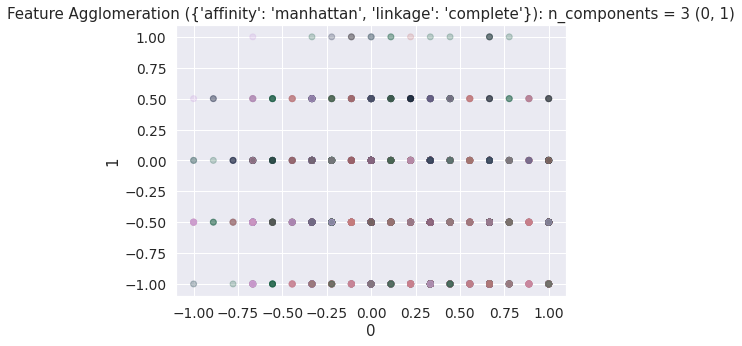

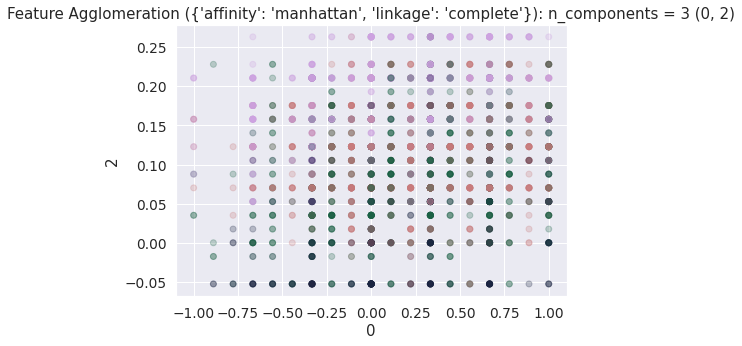

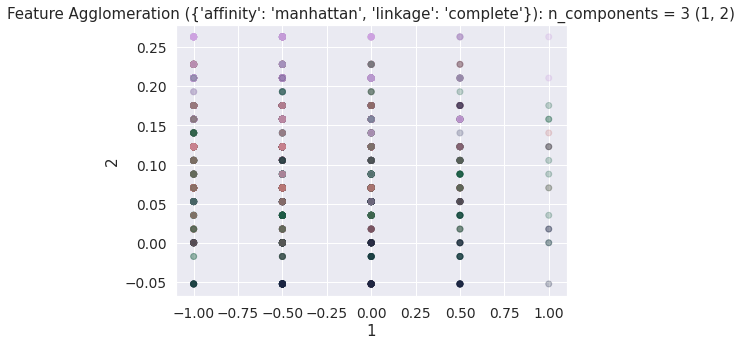

In [37]:
# Plot with governance class colors
X_fa_mixed, fa_result_mixed = compute_and_plot_feature_agglomeration(X_mixed, 3, 
                                                                     labels=df_mixed.columns,
                                                                     kwargs=kwargs_fa_mixed,
                                                                     colors=colors_gov)

The features grouped with this method could also have some relation to the politics/economics/governance question groups we defined for the faction assignments. A quick glance through our own mapping shows that the questions we indicated as related to the economics were all labeled as Feature 1, though the politics and governance questions were scattered across the two features.

#### Agglomerative clustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    Copied from scikit-learn example:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

In [ ]:
def run_agglomerative_clustering(X, nClusters, kwargs={}, X_for_plotting=None):
    """Run agglomerative clustering"""
    
    ac = AgglomerativeClustering(compute_distances=True,
                                 n_clusters=nClusters,
                                 **kwargs)
    ac = ac.fit(X)
    y_predicted = ac.labels_.astype(int)

    # Display info on clusters
    print("number of points in each cluster: ", ", ".join([f"{i}: {str(x)}" for i, x in enumerate(np.bincount(ac.labels_))]))

    # Plot dendrogram of connections between clusters
    plt.figure()
    plot_dendrogram(ac, truncate_mode="lastp", p=nClusters) 

    # Plot on appropriate number of projected views (using provided projection, if any)
    if X_for_plotting is not None:
        scatter_plot_combos(X_for_plotting, min(X_for_plotting.shape[1], 3), colors=COLORS[y_predicted])
    else:
        scatter_plot_combos(X, min(X.shape[1], 3), colors=COLORS[y_predicted])

In [ ]:
nClusters = 4 # Chosen for the number of (non-NPC-type) factions/classes in each dimension

In [ ]:
# PCA projection
run_agglomerative_clustering(X_allCat, nClusters, X_for_plotting=X_pca)
print("Mixed:")
run_agglomerative_clustering(X_mixed, nClusters, X_for_plotting=X_pca)

There is a lot of overlap between clusters, at least on this projection.

In [ ]:
# Feature agglomeration projection
print("Categorical:")
run_agglomerative_clustering(X_allCat, nClusters, X_for_plotting=X_fa_allCat)
print("Mixed:")
run_agglomerative_clustering(X_mixed, nClusters, X_for_plotting=X_fa_mixed)

The clusters do seem somewhat more localized in the feature agglomeration categorical-data projection, but it's unclear to what extent they overlap (multiple points are plotted on top of one another).